In [18]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [19]:
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
sweep = c.Sweep.load(
    initial_path=initial_path,
    day='0912',
    file_name='sweep_12h_e_Am_Xqm-1',
)
sweep.lists.keys()

dict_keys(['idx', 'repetitions', 'n_layers_quantum_block', 'n_qubits', 'qubits_measurement', 'model_uuid', 'best_loss_train', 'best_loss_test', 'loss_validation', 'time_train'])

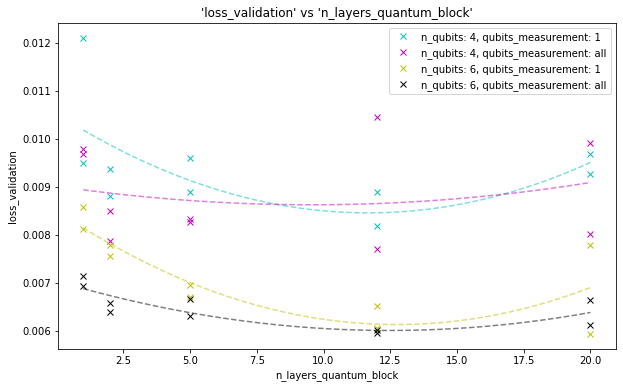

In [21]:
sweep.plot(
    x_key='n_layers_quantum_block',
    y_key='loss_validation',
    legend_keys=['n_qubits', 'qubits_measurement'],
    fit_degree=2,
    replace=[],
    fix = [],
    colors = [ 'c', 'm', 'y', 'k', 'w'],
)

In [22]:
point = sweep.get_point_min('loss_validation', fix=[('qubits_measurement', '1'), ('n_qubits', 6)])

In [23]:
import csv

def get_results_from_uuid(uuid, file_path):
    with open(file_path, mode='r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            if row['model_uuid'] == uuid:
                day, file_name = row['day'], row['file_name']
                return c.Results.load(
                    initial_path=initial_path,
                    day=day,
                    file_name=file_name,
                )
    
    return None


uuid_to_search = str(point['model_uuid'])
file_path = initial_path + '/saved/results.csv'
results = get_results_from_uuid(uuid_to_search, file_path)

In [24]:
sweep_point = point

n_qubits = sweep_point['n_qubits']
quantum_layer = q.circuit(
    n_qubits = n_qubits, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = q.parts.AmplitudeEmbedding, 
    # embedding_ansatz = q.parts.Ansatz_11,
    block_ansatz = q.parts.Ansatz_11,
    final_ansatz = q.parts.Ansatz_11,
    measurement = q.parts.Measurement('Z', sweep_point['qubits_measurement']),
    # embedding_n_layers = 4,
    # different_inputs_per_layer = True,
    block_n_layers = sweep_point['n_layers_quantum_block'],
    # wrapper_qlayer = pw.QLayerEmpty,
)

# -- MODEL -- #                    
class Model(m.Model):
    def __init__(self):
        super(Model, self).__init__()
        n_qubits_measured = n_qubits if sweep_point['qubits_measurement'] == 'all' else 1
        embedding_dim = 2**n_qubits//12
        self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=embedding_dim)
        self.fc2 = m.Reshape()
        self.fc3 = quantum_layer() 
        self.fc4 = m.nn.Linear(n_qubits_measured, n_qubits_measured) 
        self.fc5 = m.nn.Linear(n_qubits_measured, 1)

    def forward(self, x):
        # x = self.fc1(x)
        # x = self.fc2(x)
        x = self.fc3(x)
        x = m.torch.sigmoid(self.fc4(x))
        x = self.fc5(x)
        return x

model = Model()

model.load_state_dict(results.parameters_epoch.best)

<All keys matched successfully>

In [28]:
x = m.torch.randint(0, 18, (12,)) / 18 * 2 * np.pi

num_epochs = 1000
learning_rate = 5
epsilon = 0.05 

for epoch in range(num_epochs):    
    
    grad = m.torch.zeros(x.size(0))
    for i, _ in enumerate(grad):
        perturbation = m.torch.zeros(x.size(0))
        perturbation[i] = epsilon
        grad[i] = (model(x + perturbation) - model(x - perturbation)) / (2*epsilon)

    #spsa grad
    # perturbation = torch.randint(0, 2, x.size()) * 2 - 1
    # grad = (model(x + epsilon*perturbation) - model(x - epsilon*perturbation)) / (2*epsilon) * perturbation

    x = x - learning_rate * grad

    print(f"Epoch {epoch}: score = {model(x).item()}, x = {x.detach().numpy().tolist()}")

print(f"Optimized x: {x}")
print(f"Minimum score: {model(x)}")

Epoch 0: score = -0.40337850423804933, x = [0.08067941853538152, 1.7150924569930286, 1.7918987445943533, -0.0783322368441558, 5.5599476740450715, 2.84412317649682, 5.573806055363565, 3.797955485533583, 2.7679697579239395, 3.176258102266292, 3.8194280149127597, 4.24332578706604]
Epoch 1: score = -0.4082224916300513, x = [0.1587939735894578, 1.6851412160865862, 1.835762602615196, -0.1537760187317022, 5.534870153647626, 2.894031838922505, 5.562128468335596, 3.7554880342942827, 2.743601131197866, 3.2089547193284647, 3.7990640372670663, 4.296539921774459]
Epoch 2: score = -0.412782948659978, x = [0.23435645608801126, 1.6555133476786474, 1.8770189357608023, -0.22637978479043974, 5.50989130693618, 2.9422800263192093, 5.550094673002627, 3.712466642804915, 2.7194576015460226, 3.2397626401338653, 3.7786838233989206, 4.348433658809547]
Epoch 3: score = -0.4170739861864362, x = [0.3073967594563076, 1.6262394121965371, 1.9157728436421082, -0.29620702988039926, 5.48507183989947, 2.9889038421649903, 

KeyboardInterrupt: 